In [79]:
import chess
import chess.engine
import chess.syzygy
import chess.pgn
import chess.svg
import chess.polyglot
import asyncio
from flask import Flask, Response, request
import webbrowser
import time
import traceback
from datetime import date, datetime
import numpy as np
import time

In [176]:
positionsSearched = 0
pawntable = [
    0, 0, 0, 0, 0, 0, 0, 0,
    5, 10, 10, -20, -20, 10, 10, 5,
    5, -5, -10, 0, 0, -10, -5, 5,
    0, 0, 0, 20, 20, 0, 0, 0,
    5, 5, 10, 25, 25, 10, 5, 5,
    10, 10, 20, 30, 30, 20, 10, 10,
    50, 50, 50, 50, 50, 50, 50, 50,
    0, 0, 0, 0, 0, 0, 0, 0]

knightstable = [
    -50, -40, -30, -30, -30, -30, -40, -50,
    -40, -20, 0, 5, 5, 0, -20, -40,
    -30, 5, 10, 15, 15, 10, 5, -30,
    -30, 0, 15, 20, 20, 15, 0, -30,
    -30, 5, 15, 20, 20, 15, 5, -30,
    -30, 0, 10, 15, 15, 10, 0, -30,
    -40, -20, 0, 0, 0, 0, -20, -40,
    -50, -40, -30, -30, -30, -30, -40, -50]

bishopstable = [
    -20, -10, -10, -10, -10, -10, -10, -20,
    -10, 5, 0, 0, 0, 0, 5, -10,
    -10, 10, 10, 10, 10, 10, 10, -10,
    -10, 0, 10, 10, 10, 10, 0, -10,
    -10, 5, 5, 10, 10, 5, 5, -10,
    -10, 0, 5, 10, 10, 5, 0, -10,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -20, -10, -10, -10, -10, -10, -10, -20]

rookstable = [
    0, 0, 0, 5, 5, 0, 0, 0,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    5, 10, 10, 10, 10, 10, 10, 5,
    0, 0, 0, 0, 0, 0, 0, 0]

queenstable = [
    -20, -10, -10, -5, -5, -10, -10, -20,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -10, 5, 5, 5, 5, 5, 0, -10,
    0, 0, 5, 5, 5, 5, 0, -5,
    -5, 0, 5, 5, 5, 5, 0, -5,
    -10, 0, 5, 5, 5, 5, 0, -10,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -20, -10, -10, -5, -5, -10, -10, -20]

kingstable = [
    20, 30, 10, 0, 0, 10, 30, 20,
    20, 20, 0, 0, 0, 0, 20, 20,
    -10, -20, -20, -20, -20, -20, -20, -10,
    -20, -30, -30, -40, -40, -30, -30, -20,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30]


def evaluate_board():
    if board.is_checkmate():
        if board.turn:
            return -9999
        else:
            return 9999
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0
    if num_peices() <= 5:
        try:
            with chess.syzygy.open_tablebase("/Users/cshriver/Desktop/Chess-python/Syzygy-5") as tablebase:
                    if tablebase.probe_wdl(board) > 0:
                        if board.turn:
                            return 9999
                        else:
                            return -9999
                    elif tablebase.probe_wdl(board) < 0:
                        if board.turn:
                            return -9999
                        else:
                            return 9999
                    elif tablebase.probe_wdl(board) == 0:
                        return 0
        except:
            print(num_peices(), board.fen())
            print('error position not found in table base though it should be there')

    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))

    material = 100 * (wp - bp) + 320 * (wn - bn) + 330 * (wb - bb) + 500 * (wr - br) + 900 * (wq - bq)

    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq = pawnsq + sum([-pawntable[chess.square_mirror(i)]
                        for i in board.pieces(chess.PAWN, chess.BLACK)])
    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)]
                            for i in board.pieces(chess.KNIGHT, chess.BLACK)])
    bishopsq = sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq = bishopsq + sum([-bishopstable[chess.square_mirror(i)]
                            for i in board.pieces(chess.BISHOP, chess.BLACK)])
    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)])
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)]
                        for i in board.pieces(chess.ROOK, chess.BLACK)])
    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)])
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)]
                            for i in board.pieces(chess.QUEEN, chess.BLACK)])
    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)])
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)]
                        for i in board.pieces(chess.KING, chess.BLACK)])

    eval = material + pawnsq + knightsq + bishopsq + rooksq + queensq + kingsq
    # if board.turn:
    #     return eval
    # else:
    #     return -eval
    return eval

# find number of piece left on board to see if we should look at tablebases
def num_peices():
    total = 2
    for i in board.pieces(chess.QUEEN, chess.WHITE):
        if i is not None:
            total +=1
    for i in board.pieces(chess.QUEEN, chess.BLACK):
        if i is not None:
            total +=1
    for i in board.pieces(chess.ROOK, chess.WHITE):
        if i is not None:
            total +=1
    for i in board.pieces(chess.ROOK, chess.BLACK):
        if i is not None:
            total +=1
    for i in board.pieces(chess.KNIGHT, chess.WHITE):
        if i is not None:
            total +=1
    for i in board.pieces(chess.KNIGHT, chess.BLACK):
        if i is not None:
            total +=1
    for i in board.pieces(chess.BISHOP, chess.WHITE):
        if i is not None:
            total +=1
    for i in board.pieces(chess.BISHOP, chess.BLACK):
        if i is not None:
            total +=1
    for i in board.pieces(chess.PAWN, chess.WHITE):
        if i is not None:
            total +=1
    for i in board.pieces(chess.PAWN, chess.BLACK):
        if i is not None:
            total +=1

    return total


#move ordering
def moveOrdering(moves):
    result = {}
    pieceVaules = {1: 1, 2: 3, 3: 3, 4: 5, 5: 9, 6: 0}
    for move in moves:
        moveSore = 0
        if board.is_capture(move):
            # print(str(move), board.fen)
            if board.is_en_passant(move):
                moveSore += 20
            else:
                moveSore += (10 * (pieceVaules[board.piece_at(move.to_square).piece_type] - pieceVaules[board.piece_at(move.from_square).piece_type])) + 5
        if board.gives_check(move):
            moveSore += 10
        if move.promotion is not None:
            moveSore += pieceVaules[move.promotion] * 7
        if len(list(board.attackers(not board.turn, move.to_square))) > 0:
            # print(list(board.attackers(board.turn, move.to_square)).remove(move.from_square), str(move))
            deffenders = list(board.attackers(board.turn, move.to_square))
            try:
                deffenders.remove(move.from_square)
            except:
                pass
            if len(deffenders) <= 0:
                moveSore -= 100 * pieceVaules[board.piece_at(move.from_square).piece_type]
            else:
                for square in list(board.attackers(not board.turn, move.to_square)):
                    if pieceVaules[board.piece_at(square).piece_type] > pieceVaules[board.piece_at(move.from_square).piece_type]:
                        moveSore -= 5
                    else:
                        moveSore += 30 * (pieceVaules[board.piece_at(square).piece_type] - pieceVaules[board.piece_at(move.from_square).piece_type])
        result[move] = moveSore
    result = sorted(result.items(), key=lambda x: x[1], reverse=True)
    # print(result)
    finalResult = []
    for obj in result:
        finalResult.append(obj[0])
    return finalResult
moves = moveOrdering(board.legal_moves)
# print(moves)



# Searching the best move using minimax and alphabeta algorithm with negamax implementation
def alphabeta(alpha, beta, depthleft):
    global positionsSearched
    global moveGeneration
    bestscore = -9999
    if (depthleft == 0):
        # return quiesce(alpha, beta)
        return evaluate_board()
    moves = moveOrdering(board.legal_moves)
    moveGeneration += 1
    for move in moves:
        board.push(move)
        positionsSearched += 1
        score = -alphabeta(-beta, -alpha, depthleft - 1)
        board.pop()
        if (score >= beta):
            return score
        if (score > bestscore):
            bestscore = score
        if (score > alpha):
            alpha = score
    return bestscore


def quiesce(alpha, beta):
    global positionsSearched
    global moveGeneration
    stand_pat = evaluate_board()
    if (stand_pat >= beta):
        return beta
    if (alpha < stand_pat):
        alpha = stand_pat
    moves = moveOrdering(board.legal_moves)
    moveGeneration += 1
    for move in moves:
        if board.is_capture(move):
            board.push(move)
            positionsSearched += 1
            score = -quiesce(-beta, -alpha)
            board.pop()

            if (score >= beta):
                return beta
            if (score > alpha):
                alpha = score
    return alpha


def selectmove(depth):
    global positionsSearched
    global moveGeneration
    try:
        move = chess.polyglot.MemoryMappedReader("/Users/cshriver/Desktop/Chess-python/books/human.bin").weighted_choice(board).move
        # move = chess.polyglot.MemoryMappedReader("/Users/cshriver/Desktop/Chess-python/books/computer.bin").weighted_choice(board).move
        # move = chess.polyglot.MemoryMappedReader("/Users/cshriver/Desktop/Chess-python/books/human.bin").weighted_choice(board).move
        return move
    except:
        if num_peices() <= 5:
            try:
                with chess.syzygy.open_tablebase("/Users/cshriver/Desktop/Chess-python/Syzygy-5") as tablebase:
                    cur_dtz = tablebase.probe_dtz(board)
                    fastest_win = -9999
                    bestMove = chess.Move.null()
                    for move in board.legal_moves:
                        board.push(move)
                        positionsSearched += 1
                        if cur_dtz > 0:
                            if tablebase.probe_dtz(board) < cur_dtz and tablebase.probe_dtz(board) < 0:
                                if fastest_win < tablebase.probe_dtz(board):
                                    fastest_win = tablebase.probe_dtz(board)
                                    bestMove = move
                        elif cur_dtz < 0:
                            if tablebase.probe_dtz(board) == (abs(cur_dtz) - 1):
                                bestMove = move
                        elif cur_dtz == 0:
                            if tablebase.probe_dtz(board) == 0:
                                bestMove = move
                        board.pop()
                return bestMove
            except:
                print('error position not found in table base')

        bestMove = chess.Move.null()
        bestValue = -99999
        alpha = -100000
        beta = 100000
        moves = moveOrdering(board.legal_moves)
        moveGeneration += 1
        for move in moves:
            board.push(move)
            positionsSearched += 1
            boardValue = -alphabeta(-beta, -alpha, depth - 1)
            if boardValue > bestValue:
                bestValue = boardValue
                bestMove = move
            if (boardValue > alpha):
                alpha = boardValue
            board.pop()
        return bestMove
        # return alphabeta()

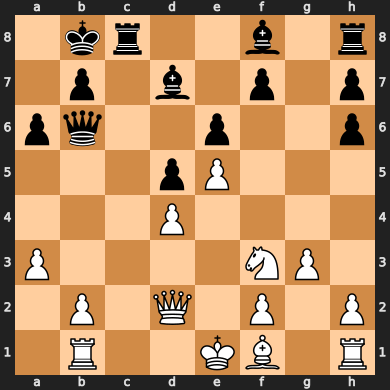

In [236]:
pos1 = '1kr2b1r/1p1b1p1p/pq2p2p/3pP3/3P4/P4NP1/1P1Q1P1P/1R2KB1R b K - 2 16'
pos2 = '1kr5/1pqb1pbp/p1R1p2p/3pP3/3P4/P4NP1/1P1QBP1P/5RK1 b - - 0 20'
pos3 = '3R2r1/8/2N1bk2/8/8/7P/r4P2/4K2R b K - 3 29'

board = chess.Board(pos1)
board

In [232]:
start_time = time.time()
positionsSearched = 0
moveGeneration = 0
print(selectmove(4))
print("--- %s seconds ---" % (time.time() - start_time))
print(positionsSearched)
print(moveGeneration)

g8g1
--- 3.615103006362915 seconds ---
13401
3152


In [237]:
start_time = time.time()
depth = 4
positionsSearched = 0
print(selectmoveTwo(4))
print (positionsSearched)
print("--- %s seconds ---" % (time.time() - start_time))

f8a3
73011
--- 12.926679134368896 seconds ---


In [221]:
def minimax(depth, alpha, beta, maximizingPlayer):
    global positionsSearched
    if depth == 0 or board.is_game_over():
        return evaluate_board()

    moves = moveOrdering(board.legal_moves)
    if maximizingPlayer:
        maxVaule = -9999
        for move in moves:
            positionsSearched += 1
            board.push(move)
            vaule = minimax(depth -1, alpha, beta, False)
            board.pop()
            maxVaule = max(vaule, maxVaule)
            alpha = max(alpha, vaule)
            if beta <= alpha:
                break
        return maxVaule
    else:
        minVaule = 9999
        for move in moves:
            positionsSearched += 1
            board.push(move)
            vaule = minimax(depth -1, alpha, beta, True)
            board.pop()
            minVaule = min(vaule, minVaule)
            beta = min(beta, vaule)
            if beta <= alpha:
                break
        return minVaule

In [230]:
def selectmoveTwo(depth):
    global positionsSearched
    try:
        move = chess.polyglot.MemoryMappedReader("/Users/cshriver/Desktop/Chess-python/books/human.bin").weighted_choice(board).move
        # move = chess.polyglot.MemoryMappedReader("/Users/cshriver/Desktop/Chess-python/books/computer.bin").weighted_choice(board).move
        # move = chess.polyglot.MemoryMappedReader("/Users/cshriver/Desktop/Chess-python/books/human.bin").weighted_choice(board).move
        return move
    except:
        if num_peices() <= 5:
            try:
                with chess.syzygy.open_tablebase("/Users/cshriver/Desktop/Chess-python/Syzygy-5") as tablebase:
                    cur_dtz = tablebase.probe_dtz(board)
                    fastest_win = -9999
                    bestMove = chess.Move.null()
                    for move in board.legal_moves:
                        board.push(move)
                        # positionsSearched += 1
                        if cur_dtz > 0:
                            if tablebase.probe_dtz(board) < cur_dtz and tablebase.probe_dtz(board) < 0:
                                if fastest_win < tablebase.probe_dtz(board):
                                    fastest_win = tablebase.probe_dtz(board)
                                    bestMove = move
                        elif cur_dtz < 0:
                            if tablebase.probe_dtz(board) == (abs(cur_dtz) - 1):
                                bestMove = move
                        elif cur_dtz == 0:
                            if tablebase.probe_dtz(board) == 0:
                                bestMove = move
                        board.pop()
                return bestMove
            except:
                print('error position not found in table base')
                bestMove = chess.Move.null()

        maximizingPlayer = board.turn
        bestMove = chess.Move.null()
        alpha = -100000
        beta = 100000
        moves = moveOrdering(board.legal_moves)

        if maximizingPlayer:
            maxVaule = -9999
            for move in moves:
                positionsSearched += 1
                board.push(move)
                vaule = minimax(depth -1, alpha, beta, False)
                board.pop()
                if vaule > maxVaule:
                    maxVaule = vaule
                    bestMove = move
                alpha = max(alpha, vaule)
                if beta <= alpha:
                    break
        else:
            minVaule = 9999
            for move in moves:
                positionsSearched += 1
                board.push(move)
                vaule = minimax(depth -1, alpha, beta, True)
                board.pop()
                if vaule < minVaule:
                    minVaule = vaule
                    bestMove = move
                beta = min(beta, vaule)
                if beta <= alpha:
                    break
        return bestMove

In [144]:
def negamax(alpha, beta, depth):
    global positionsSearched
    if depth == 0 or board.is_game_over():
        return {'vaule': evaluate_board(), 'move': None}
    moves = moveOrdering(board.legal_moves)
    bestVaule = -9999
    for move in moves:
        board.push(move)
        positionsSearched += 1
        currentVaule = -(negamax(-alpha, -beta, depth-1)['vaule'])
        board.pop()
        # print(move, currentVaule)
        # print('bestVaule', bestVaule, 'alpha', alpha, 'beta', beta)
        if currentVaule > bestVaule:
            bestVaule = currentVaule
            bestMove = move
        if bestVaule > alpha:
            alpha = bestVaule
        if bestVaule >= beta:
            print('bestVaule', bestVaule, 'alpha', alpha, 'beta', beta)
            print('prunned')
            break

    return {'vaule': bestVaule, 'move': bestMove}

In [17]:
start_time = time.time()
for i in range(5077):
    moves = moveOrdering(board.legal_moves)
    for move in moves:
        board.push(move)
        board.pop()
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.722693920135498 seconds ---


In [72]:
board = chess.Board()

now = datetime.now()

game = chess.pgn.Game()
moveHistory = []
timeHistory = []
first = True
turn = True

while not board.is_game_over():
    start_time = time.time()
    if turn:
        result = selectmoveTwo(3)
        turn = not turn
    else:
        result = selectmove(3)
    moveHistory.append(str(result))
    board.push(result)
    timeHistory.append("--- %s seconds ---" % (time.time() - start_time))

game.headers['Event'] = 'online'
game.headers['Site'] = 'python-chess'
game.headers['Date'] = now.strftime("%d/%m/%Y %H:%M:%S")
game.headers['Round'] = 'Single Game'
game.headers['White'] = 'negamax'
game.headers['Black'] = 'oldAlgo'
game.headers['Result'] = board.result() 


for move in moveHistory:
    if first:
        node = game.add_variation(chess.Move.from_uci(move))
        first =False
    else:
        node = node.add_variation(chess.Move.from_uci(move))
    
# print(moveHistory)
print(timeHistory)
print(game)



['--- 0.0236508846282959 seconds ---', '--- 0.0015099048614501953 seconds ---', '--- 0.0019502639770507812 seconds ---', '--- 0.0014870166778564453 seconds ---', '--- 0.0012001991271972656 seconds ---', '--- 0.0013251304626464844 seconds ---', '--- 0.012891292572021484 seconds ---', '--- 0.02669501304626465 seconds ---', '--- 0.0010209083557128906 seconds ---', '--- 0.0011849403381347656 seconds ---', '--- 0.0010650157928466797 seconds ---', '--- 0.0012269020080566406 seconds ---', '--- 0.0010647773742675781 seconds ---', '--- 0.0009140968322753906 seconds ---', '--- 0.0004107952117919922 seconds ---', '--- 0.0008618831634521484 seconds ---', '--- 0.0008640289306640625 seconds ---', '--- 0.0005600452423095703 seconds ---', '--- 0.0004470348358154297 seconds ---', '--- 1.0307238101959229 seconds ---', '--- 1.2054059505462646 seconds ---', '--- 4.372467994689941 seconds ---', '--- 0.9095790386199951 seconds ---', '--- 2.0686938762664795 seconds ---', '--- 2.9500732421875 seconds ---', '-

In [124]:
print(moveOrdering(board.legal_moves))

[Move.from_uci('h8g8'), Move.from_uci('f8g7'), Move.from_uci('f8e7'), Move.from_uci('c8e8'), Move.from_uci('c8d8'), Move.from_uci('c8c7'), Move.from_uci('c8c6'), Move.from_uci('b8a8'), Move.from_uci('b8c7'), Move.from_uci('b8a7'), Move.from_uci('d7e8'), Move.from_uci('d7c6'), Move.from_uci('d7b5'), Move.from_uci('d7a4'), Move.from_uci('b6d8'), Move.from_uci('b6c7'), Move.from_uci('b6a7'), Move.from_uci('b6c6'), Move.from_uci('b6b3'), Move.from_uci('h6h5'), Move.from_uci('f7f5'), Move.from_uci('a6a5'), Move.from_uci('f8d6'), Move.from_uci('f8c5'), Move.from_uci('c8c4'), Move.from_uci('f8b4'), Move.from_uci('f7f6'), Move.from_uci('c8c5'), Move.from_uci('b6b5'), Move.from_uci('b6d6'), Move.from_uci('b6c5'), Move.from_uci('b6b4'), Move.from_uci('f8a3'), Move.from_uci('c8c1'), Move.from_uci('c8c3'), Move.from_uci('c8c2'), Move.from_uci('b6a5'), Move.from_uci('b6d4'), Move.from_uci('b6b2')]


In [150]:
if not board.turn:
    print('hello')

hello


In [177]:
print(evaluate_board())

220


In [211]:
x = 1000
x = min(10, x)
print(x)

10
